**SARIMAX** (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors): is an updated version of the ARIMA model.SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA.

This Notebook tests SARIMAX for a single store. The result of the same is the demand for a particular store.

To read more about Sarimax and ARIMA : [Click Here](https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def)

In [61]:
# import the usual modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_rows", 20)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plot
import os
import warnings
#import funcs
from datetime import datetime
# from matplotlib.pyplot import cm
import random
from sklearn import metrics
#importing neccesary libraries

In [62]:
#importing neccesary libraries
pd.set_option("display.max.columns",None)
pd.set_option("display.max.rows",None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew



Instruction : If running on Google colab, place the dataset in your drive. The below given cells simply extracts the data from there.

In [63]:
from google.colab import drive
drive.mount('/content/drive') #connects colab with your drive to extract data from there

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
train = pd.read_csv("/content/drive/MyDrive/walmart/train[1].csv") # saving data into dataframe
features = pd.read_csv('/content/drive/MyDrive/walmart/features[1].csv') # saving data into dataframe
sample = pd.read_csv('/content/drive/MyDrive/walmart/sampleSubmission.csv') # saving data into dataframe
stores  = pd.read_csv('/content/drive/MyDrive/walmart/stores[1].csv') # saving data into dataframe
test = pd.read_csv('/content/drive/MyDrive/walmart/test[1].csv') # saving data into dataframe

In [65]:
#merging different datasets 
store_features = stores.merge(features,on = 'Store',how = 'inner')
store_data = train.merge(store_features,on = ['Store','Date'],how = 'right')
dataset = store_data.drop(columns = ['Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5','Unemployment'],axis = 1)

In [66]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,CPI,IsHoliday_y
0,1,1.0,2010-02-05,24924.50,False,A,151315,211.096358,False
1,1,2.0,2010-02-05,50605.27,False,A,151315,211.096358,False
2,1,3.0,2010-02-05,13740.12,False,A,151315,211.096358,False
3,1,4.0,2010-02-05,39954.04,False,A,151315,211.096358,False
4,1,5.0,2010-02-05,32229.38,False,A,151315,211.096358,False


In [67]:
dataset_for_prediction=dataset.dropna() #droping null values

In [68]:
dataset_grouped = dataset_for_prediction.groupby(['Date','Store','Dept','CPI','Type'])['Weekly_Sales'].sum().reset_index() #grouping the data

In [69]:
Store1 = dataset_grouped[dataset_grouped.Store.isin([1])] #extracting_data_for_store_1

In [70]:
Store1.head()


,Date,Store,Dept,CPI,Type,Weekly_Sales
0,2010-02-05,1,1.0,211.096358,A,24924.50
1,2010-02-05,1,2.0,211.096358,A,50605.27
2,2010-02-05,1,3.0,211.096358,A,13740.12
3,2010-02-05,1,4.0,211.096358,A,39954.04
4,2010-02-05,1,5.0,211.096358,A,32229.38


In [71]:
steps=0
dataset_for_prediction1= Store1.copy()
# dataset_for_prediction1['Actual_sales']=dataset_for_prediction1['Weekly_Sales'].shift(steps)
dataset_for_prediction1.head(3)

,Date,Store,Dept,CPI,Type,Weekly_Sales
0,2010-02-05,1,1.0,211.096358,A,24924.50
1,2010-02-05,1,2.0,211.096358,A,50605.27
2,2010-02-05,1,3.0,211.096358,A,13740.12


In [72]:
dataset_grouped = dataset_for_prediction1.groupby(['Date','Store','CPI','Type'])['Weekly_Sales'].sum().reset_index() 

In [73]:
dataset_for_prediction2=dataset_grouped.dropna() #dropping null values
dataset_for_prediction2['Date'] =pd.to_datetime(dataset_for_prediction2['Date']) # converting data type to datetimens[]
dataset_for_prediction2.index= dataset_for_prediction2['Date'] #setting it to index 

In [74]:
dataset_for_prediction2.Store.value_counts()
Store1 = dataset_for_prediction2.copy()

1    143
Name: Store, dtype: int64

In [75]:

Store1 = dataset_grouped[(dataset_grouped.Store==1)] # taking out data for a single store in this example we take it for store type 1
steps=-1
dataset_for_prediction1= Store1.copy() 
dataset_for_prediction1['Actual_sales']=dataset_for_prediction1['Weekly_Sales'].shift(steps) #shiftting weekly sales by one row
dataset_for_prediction1=dataset_for_prediction1.dropna() #dropping the null value created during shifting 
dataset_for_prediction1['Date'] =pd.to_datetime(dataset_for_prediction1['Date'])  # converting data type to datetimens[]
dataset_for_prediction1.index= dataset_for_prediction1['Date']
# dataset_for_prediction1.head()
X = dataset_for_prediction1[['Store','CPI','Weekly_Sales']] # Taking out specific features for feature class
y = dataset_for_prediction1[['Actual_sales']] # target class
y.rename(columns={'Actual_sales':'Next_week_Sale'},inplace = True) #renaming actual sales 
train_size=int(len(Store1) *0.65)
test_size = int(len(Store1)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Seasonal decomposition using moving averages.



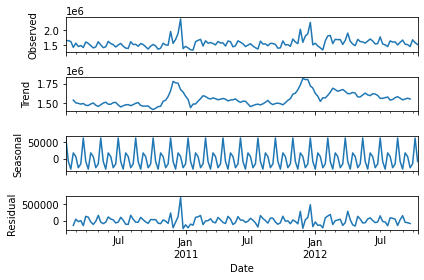

In [76]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Weekly_Sales'],model='add',freq=7); #( timeseries array, type of seasonality additive or multiplicative, extrapolate_trend)
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

Adfuller test to reject or accept hypothesis based on P-Value

In [77]:
from statsmodels.tsa.stattools import adfuller #AdFuller Test for accepting or rejecting null hypothesis to check if data is stationary or not
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct') #series, AutoLag = AIC ( minimize the corresponding information criterion) , regression = constant and trend 
    for key,val in dftest[4].items(): #dftest returns   
        dfout[f'critical value ({key})']=val #critical values 1%, 5%, 10% , distribution formula --> lag coeff/standard error(lag coeff)
    if dftest[1]<=0.05: #pvalue barrier to accept/reject hypothesis 
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [78]:
y_test=y['Next_week_Sale'][:train_size].dropna()
test_adf(y_test, " Weekly Sales")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Weekly Sales


In [79]:
!pip install pmdarima

In [80]:
from pmdarima.arima import auto_arima #auto-arima finds optimal order for an various differencing tests 
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, #defining values of pdq to test for
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

#finding the best values of p, d, q 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2455.400, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2451.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2453.318, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2453.342, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2769.879, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.275 seconds


In [81]:
step_wise.summary() #breif statistics 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1220.687
Date:                Mon, 21 Feb 2022   AIC                           2451.374
Time:                        21:30:07   BIC                           2463.928
Sample:                    02-05-2010   HQIC                          2456.438
                         - 11-04-2011                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -2238.4177    1.9e+04     -0.118      0.906   -3.95e+04     3.5e+04
Store                 0        nan        nan        nan         nan         nan
CPI           2.616e+04   1.23e+05      0.212      0.832   -2.16e+05    2.68e+05
Weekly_Sales    -0.3679      0.054     -6.872      0.000      -0.473      -0.263
sigma2        2.624e+10      1.027   2.55e+10      0.000    2.62e+10    2.62e+10
===================================================================================
Ljung-Box (Q):                       43.04   Jarque-Bera (JB):               256.87
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.61
Prob(H) (two-sided):                  0.64   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.36e+28. Standard errors may be unstable.
"""

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#seasonal_order = (p,d,q,seasonality) here we considered the seasonality to be 52W
model= SARIMAX(train_y, seasonal_order=(0,1,0,52),
 exog=train_X,
 order=(0,1,0), #p,d,q
 enforce_invertibility=False, enforce_stationarity=False)

results= model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  periods=len(index) + 1,
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  iterations : int
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2060: RuntimeWarning: invalid value encountered in true_divide
  cases are the strings 'start' and 'end', which refer to setting the


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     Next_week_Sale   No. Observations:                   92
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -525.259
Date:                            Mon, 21 Feb 2022   AIC                           1058.519
Time:                                    21:30:07   BIC                           1065.069
Sample:                                02-05-2010   HQIC                          1060.849
                                     - 11-04-2011                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Store                 0         -0        nan        nan           0           0
CPI           2.546e+04   1.22e+06      0.021      0.983   -2.36e+06    2.42e+06
Weekly_Sales    -0.5718      5.331     -0.107      0.915     -11.021       9.878
sigma2        1.574e+11      0.354   4.45e+11      0.000    1.57e+11    1.57e+11
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                25.69
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.17
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

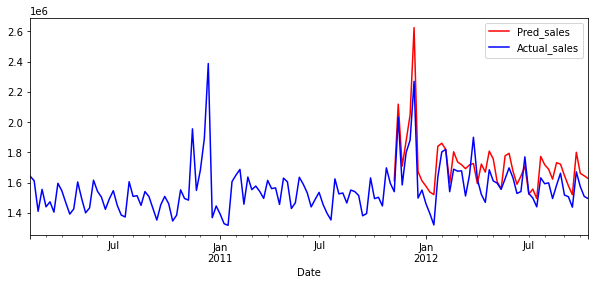

In [83]:
%matplotlib inline
# steps = -1
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
act= pd.DataFrame(y.iloc[train_size:, :])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True) # not inserting index 
predictions.index=test_X.index #setting index
predictions['Actual_sales'] = act['Next_week_Sale'] #to compare the test and train values
predictions.rename(columns={0:'Pred_sales'}, inplace=True)
Final_predictions = pd.concat([predictions,act],axis=1)
# Final_predictions['Pred_sales'].plot(legend=True, color='red', figsize=(20,8))
# dataset_for_prediction2['Actual_sales'].plot(legend=True, color='blue', figsize=(20,8))
fig=Final_predictions['Pred_sales'].plot(legend=True, color='red', figsize=(10,4))
fig=dataset_for_prediction1['Actual_sales'].plot(legend=True, color='blue')
# fig.set_figheight(4)
plt.show()


In [84]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred_sales'], predictions['Actual_sales'])
error #Root-mean-square deviation for finding the error.

125163.36778327901